# Projet informatique

Naïla El Haouari - ENSAE 3A DSSS - Avril 2020 - https://github.com/Naila-elh/Covid19-Analysis

Alors qu'une bonne partie des pays est confinée depuis plusieurs semaines en raison de l'épidémie de COVID19, il nous a semblé judicieux d'étudier cette thématique. La large utilisation des réseaux sociaux ces dernières années pour exprimer ses émotions et partager des informations nous a semblé intéressante pour analyser un tel phénomène, et ce d'autant plus qu'en période de confinement, ce sont principalement ces mêmes outils informatiques qui permettent aux individus de maintenir le lien social.

Ce projet comprend deux axes d'analyse. D'une part, nous cherchons à étudier dans quelle mesure les réseaux sociaux sont un bon moyen pour prédire l'évolution de l'épidémie. En effet, on peut supposer que les individus ayant des symptômes semblables au COVID s'expriment sur les réseaux sociaux ; et on peut espérer voir une corrélation entre les tweets mentionnant des symptômes et le nombre de cas / hospitalisations. En analysant localement ces tweets, par département ou région, cela pourrait alors être un indicateur des régions les plus/moins touchées.

D'autre part, nous analysons l'évolution au cours du temps des sentiments et émotions qui émanent des tweets liés au COVID. Des travaux similaires ont eu lieu et nous laissent penser que l'épidémie de COVID a pu avoir un impact très négatif sur le moral des individus (Voir https://hedonometer.org/ qui observe une chute spectaculaire dans les sentiments exprimés dans les tweets en anglais, au moment de l'épidémie de COVID).

Dans cette étude, nous nous sommes concentrés sur la région Île-de-France pour des questions pratiques : il s'agit de la région avec la plus forte densité de population, ce qui signifie que l'on a pu récupérer plus rapidement des tweets ; et il s'agit également d'une région fortement touchée par le COVID19. 

# 0. Config

## Récupération des données Twitter

La récupération des données Twitter a fait l'objet d'une grosse partie de ce projet. Le code est disponible dans d'autres fichiers .ipynb sur Github (lien au début de ce notebook), dans les folders "1-streaming/" et "2-history/".

Pour récupérer les tweets provenant de cette région, nous avons procédé en deux étapes. Tout d'abord, on a utilisé l'API Twitter "Streaming" pour récupérer localement une partie des tweets émis en région parisienne en temps réel : cette API permet "d'écouter" Twitter en temps réel, mais nous ne récupérons qu'une fraction des tweets. Comme nous souhaitons effectuer une analyse temporelle, on a utilisé l'API de Twitter pour récupérer les données historiques des utilisateurs récupérés en "stream" : cela nous a permis de récupérer, pour 13 000 utilisateurs, les "timelines" (l'historique des tweets).

Cette technique signifie que l'on n'analyse pas les tweets de tous les individus en région parisienne, mais uniquement les tweets des personnes localisées en région parisienne dont on a streamé des tweets. Cela signifie également que l'on suit les mêmes personnes au cours du temps.

En raison de la grande quantité de tweets et d'historiques récupérés, j'ai eu à utiliser divers outils pour traiter ces importants jeux de données, en passant notamment par de la parallélisation de fonctions. J'ai également travaillé sur un serveur, mis à disposition par le CRI Paris (où j'ai déjà commencé mon stage de fin d'études à temps partiel), pour accélérer le temps de traitement des données.

## Ouverture des données

In [1]:
import pandas as pd
import numpy as np
import json
import os
import multiprocessing as mp
from time import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths to data
path_to_data = "../data/"
path_to_timeline=os.path.join(path_to_data,'timelines/API/IDF/')
path_to_external_data = os.path.join(path_to_data, "external-data/")

In [3]:
json_files = sorted([x for x in os.listdir(path_to_timeline) if x[-4:]=='json'])

def get_tweets(index_block,n_blocks):
    df=pd.DataFrame()
    for json_file in json_files[n_blocks*index_block:n_blocks*(index_block+1)]:
        #print(str(json_file))
        with open(path_to_timeline+json_file, 'r') as f:
            tweets_user = pd.DataFrame(json.load(f))
            df = pd.concat([df,tweets_user])
    return df

In [4]:
# Parallelization
n_cpu = mp.cpu_count()
print('USE DEFAULT # CORES')
pool  = mp.Pool(processes=n_cpu)
print("# PROCESSORS:", n_cpu, "\n")

print("Read Tweets ...")
start = time()

# COMPUTE LIST OF RESULTS
n_blocks= len(json_files)//n_cpu + len(json_files)%n_cpu
print(n_blocks)
results = [pool.apply_async(get_tweets, args=(index_block,n_blocks)) for index_block in range(n_cpu)]
print(results)
tweets  = pd.concat([results[index_block].get() for index_block in range(n_cpu)]).reset_index(drop=True)
print('done')

pool.close()    
print("DONE IN", round(time() - start), "SEC")

USE DEFAULT # CORES
# PROCESSORS: 16 

Read Tweets ...
15
[<multiprocessing.pool.ApplyResult object at 0x7ffa46c9aa10>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9ac10>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9acd0>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9ad90>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9ae50>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9af90>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39090>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39150>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39210>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9af50>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39310>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f393d0>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39490>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39550>, <multiprocessing.pool.ApplyResult object at 0x7ffa80f39610>, <multiprocessing.pool.Appl

In [5]:
#tweets = pd.read_json(r'../data/timelines_concat/tweets_historic_idf_100.json', orient='index')

In [6]:
tweets.head()

,id_str,user_id,user_name,full_text,created_at,lang
0,1254698115971649537,1079923950,quelqu’un,Ça fait 10 min j’attend mon client je vais fin...,Mon Apr 27 09:05:16 +0000 2020,fr
1,1254697635845492736,1079923950,quelqu’un,Télétravail c’est pas pour moi,Mon Apr 27 09:03:22 +0000 2020,fr
2,1254695258442600448,1079923950,quelqu’un,On arrive même pas à ce motiver entre collègue...,Mon Apr 27 08:53:55 +0000 2020,fr
3,1254695106411671552,1079923950,quelqu’un,J’arrive à bout de ma motivation,Mon Apr 27 08:53:19 +0000 2020,fr
4,1254499321741037572,1079923950,quelqu’un,"RT @joanalsl: Quiero besarte de nuevo, ¿te gus...",Sun Apr 26 19:55:20 +0000 2020,es


In [7]:
len(tweets)

31914562

# 1. Cleaning dataset

Dans un premier temps, on ne choisit de garder que les tweets après le 1er décembre 2019 : cela nous permet de comparer l'évolution de certains termes avant et après le début de l'épidémie de COVID.

In [5]:
# Reducing the length of the data to make further processes faster
tweets=tweets[tweets['created_at'].str.contains('2020|2019')]

In [6]:
def convert_to_datetime(dt_series):
    def get_split_date(strdt):
        split_date = strdt.split()
        str_date = split_date[1] + ' ' + split_date[2] + ' ' + split_date[5] + ' ' + split_date[3]
        return str_date
    dt_series = pd.to_datetime(dt_series.apply(lambda x: get_split_date(x)), format = '%b %d %Y %H:%M:%S')
    return dt_series

In [7]:
def clean_dataset(df):
    
    # keep only tweets since last December
    df['created_at'] = convert_to_datetime(df['created_at'])
    df=df[df['created_at'] > '2019-12-01']
    df['day'] = df['created_at'].dt.floor('d')
    
    # identify retweets
    df['retweet'] = (df['full_text'].str.startswith('rt '))
    
    # text : to lowercase
    df['full_text'] = df['full_text'].apply(lambda x: x.lower())
    return df

In [8]:
tweets = clean_dataset(tweets)

In [12]:
print("Nombre de tweets : %d" % len(tweets))
print("Nombre de users : %d" % len(tweets['user_id'].unique()))

Nombre de tweets : 10717325
Nombre de users : 12905


# 2. Symptoms analysis

## 2.1. Construction of covid-related words

On construit des indicateurs, afin d'identifier les tweets contenant des termes liés au COVID19, ainsi qu'à la quarantaine.

In [9]:
tweets.loc[tweets['full_text'].str.contains('covid|corona |coronavirus'), 'covid'] = 1
tweets.loc[tweets['full_text'].str.contains('confin|quarantaine'), 'confinement'] = 1
tweets.loc[tweets['full_text'].str.contains('je reste chez moi|jerestechezmoi|restezchezvous|restez chez vous'),'RestezChezVous'] = 1

In [14]:
print("Tweets about covid (all tweets) : %d" % len(tweets.loc[tweets['covid']==1]))
print("Tweets about covid (without retweets) : %d" % len(tweets.loc[(tweets['covid']==1) & (tweets['retweet']==0)]))

Tweets about covid (all tweets) : 342617
Tweets about covid (without retweets) : 342617


On construit également un dictionnaire de symptômes, couvrant les symptômes liés au COVID, pour identifier le nombre d'individu mentionnant ces symptômes. On inclut également le terme "symptômes", car des individus peuvent l'utiliser spécifiquement dans le cas du COVID. 

Bien évidemment, la mention de ces symptômes n'indique pas forcément le fait que l'individu est malade du COVID. D'une part, il peut s'agir de la grippe, mais on comparera l'évolution de l'utilisation de ces termes par rapport à décembre 2019 ; d'autre part, les tweets peuvent mentionner d'autres individus, ou être au négatif.

On cherchera alors à comparer l'évolution de l'utilisation de ces termes avec des données hospitalières, afin de voir si les tweets peuvent nous informer de l'évolution de l'épidémie en Île-de-France.

In [15]:
symptoms_dict_fr = {'toux' : ['toux', 'tousse'],
                   'maux de gorge' : ['maux de gorge', 'mal de gorge', 'mal à la gorge'],
                   'fièvre' : ['fievre', 'fièvre', 'fiévre'],
                    'mal de tête' : ['mal de tête','mal de crâne','mal à la tête','mal de tete','mal de crane','mal à la tete'],
                   'perte goût et odorat' : ['perte du goût', "perte de l'odorat", 'perte du gout'],
                   'engelures' : ['engelures'],
                   'symptômes' : ['symptome', 'symptôme'],
                   'difficultés respiratoires' : ['difficultés à respirer', 'difficultés respiratoires', 'difficulté à respirer','mal à respirer'],
                   'hospitalisation' : ['hôpital','hopital','hospital','réanim','reanim']}

for symptom in symptoms_dict_fr.keys():
    tweets[symptom] = 0
    tweets.loc[tweets['full_text'].str.contains(('|').join(symptoms_dict_fr.get(symptom))), symptom] = 1
    if symptom != 'hospitalisation' :
        tweets.loc[tweets[symptom]==1, 'has_symptom'] = 1

In [16]:
print("Tweets about symptoms (all tweets) : %d" % len(tweets.loc[tweets['has_symptom']==1]))
print("Tweets about symptoms (without retweets) : %d" % len(tweets.loc[(tweets['has_symptom']==1) & (tweets['retweet']==0)]))

Tweets about symptoms (all tweets) : 13051
Tweets about symptoms (without retweets) : 13051


## 2.2. Visualisation

On représente visuellement l'évolution des tweets mentionnant des termes liés au COVID avec le package plotly. Celui-ci nous permet de visualiser de façon interactive ces évolutions (fichier HTML, possibilité de sélectionner les variables d'intérêt).

In [19]:
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
py.init_notebook_mode(connected = True)

In [18]:
def plot_covid_evolution() :
    traces=[]
    df = tweets[['day','covid','confinement','has_symptom','RestezChezVous']].groupby('day').agg('sum')
    for value in ['covid','confinement','has_symptom','RestezChezVous']:
        traces.append(go.Scatter(x = df.index, 
                                 y = df[value].values,
                                mode = 'lines',
                                name = value))
    layout = go.Layout(title="Evolution of mentions of Covid-related terms in Ile-de-France")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_covid_evolution()

In [19]:
def plot_symptoms_evolution() :
    traces=[]
    df = tweets[['day'] + list(symptoms_dict_fr.keys())].groupby('day').agg('sum')
    for symptom in symptoms_dict_fr.keys():
        traces.append(go.Scatter(x = df.index, 
                                 y = df[symptom].values,
                                mode = 'lines',
                                name = symptom))
    layout = go.Layout(title="Evolution of symptoms in Ile-de-France")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_symptoms_evolution()

In [20]:
def plot_symptoms_evolution() :
    traces=[]
    df = pd.merge(tweets[['day','covid','confinement'] + list(symptoms_dict_fr.keys())].groupby('day').agg('sum'), 
             tweets[['day','id_str']].groupby('day').agg('count').rename(columns={'id_str':'count'}),
            on='day')
    symptoms_pct = []
    for symptom in list(symptoms_dict_fr.keys())+['covid','confinement'] :
        df[symptom+'_pct'] = df[symptom]/df['count']*100
        symptoms_pct.append(symptom+'_pct')    
        
    for symptom in symptoms_pct:
        traces.append(go.Scatter(x = df.index, 
                                 y = df[symptom].values,
                                mode = 'lines',
                                name = symptom))
    layout = go.Layout(title="Evolution of symptoms in Ile-de-France (in proportion of tweets)")
    fig = go.Figure(traces, layout)
    #fig.show('png')
    py.iplot(fig)
plot_symptoms_evolution()

On constate que les premières mentions du COVID et des symptômes sont autour du 24 janvier (date des premiers cas de COVID en France). Puis, on observe une forte augmentation du nombre de tweets mentionnant le COVID à partir du 6 mars, et le "confinement" à partir du 15 mars (pour rappel, le confinement a débuté en France le 17 mars).
puis les tweets mentionnant des symptômes augmentent fortement à partir de début mars. Les plus importants sont les termes à propos de la toux, fièvre, et du terme "symptôme".

L'analyse des symptômes présente également de l'intérêt : on observe une véritable augmentation de la mention de certains symptômes (principalement liés à la toux, à la fièvre, et le terme général "symptôme"), avec également un pic autour du 24 janvier, et une augmentation plus progressive autour du 14 mars, puis une diminution dès fin avril. Par ailleurs, le nombre de tweets faisant mention de ces symptômes en décembre (probablement lié à la grippe saisonnière) est très faible, ce qui peut nous permettre d'assimiler cette forte augmentation au COVID.

Notons également qu'au début du confinement, le nombre de tweets liés au COVID représente près de 12% du nombre total de tweets (des personnes suivies en Île-de-France), et les tweets liés au confinement en représentent 8%.

## 2.3. Comparison with number of hospitalized victims of covid

Notre objectif est de savoir les informations que l'on peut tirer des réseaux sociaux quant à l'évolution de l'épidémie ; et donc d'étudier si les mentions de symptômes liés au COVID sont bien représentatifs de la réalité de la propagation de l'épidémie en Île-de-France.

Pour cela, nous comparons nos données obtenues sur Twitter avec les données des urgences hospitalières et de SOS médecins relatives à l'épidémie de COVID19 (base OSCOUR), mises à disposition par Santé Publique France : https://www.data.gouv.fr/fr/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/. On choisit ces données plutôt que le nombre de cas, car celui-ci est très dépendant du nombre de décès et assez critiqué ; et également parce que ces données sont disponibles par département.

Les données de la base OSCOUR comprennent des informations sur le nombre de passages aux urgences/SOS médecin pour des suspections de cas de COVID, les hospitalisations pour suspection de cas de COVID, et les actes chirurgicaux pour suspicion de cas de COVID. Ces données sont actualisées quotidiennement.

In [21]:
# Loading data from Santé Publique France
urgences = pd.read_csv(os.path.join(path_to_external_data,"sante-publique-france", "sursaud-covid19-quotidien-2020-04-28-19h00-departement.csv"), sep=",")

# Keep only Île-De-France
urgences = urgences.loc[urgences['dep'].isin(['75','77','78','91','93','94','95'])].groupby('date_de_passage').agg('sum').reset_index()
urgences['date_de_passage'] = pd.to_datetime(urgences['date_de_passage'])

In [22]:
# Time series of symptoms
tweets_symptoms = tweets[['day','has_symptom']].groupby('day').agg('sum').reset_index()

In [23]:
def plot_symptoms_urgences() :
    traces=[]
    traces.append(go.Scatter(x = tweets_symptoms['day'],
                            y = tweets_symptoms['has_symptom'].values,
                            mode = 'lines',
                            name = 'has_symptoms',
                            yaxis="y1"))
    for type_urgence in ['nbre_pass_corona','nbre_hospit_corona','nbre_acte_corona']:
        traces.append(go.Scatter(x = urgences.date_de_passage, 
                                 y = urgences[type_urgence],
                                 mode = 'lines',
                                 name = type_urgence,
                                 yaxis="y2"))
    
    layout = go.Layout(title="Evolution of mentions of Covid-related terms in Ile-de-France",
                       yaxis=dict(title='Number of tweets'),
                       yaxis2=dict(title='Number of acts in urgences',
                                   overlaying='y',
                                   side='right'))
    
    fig = go.Figure(traces, layout)
    py.iplot(fig)
    
plot_symptoms_urgences()

On constate qu'il semble y avoir une assez forte corrélation - et un décalage d'une dizaine de jours - entre le nombre de tweets mentionnant des symptômes et les données de passages/hospitalisation pour COVID. 

On analyse alors la cross-correlation entre l'évolution des tweets mentionnant des symptômes, et la série de l'évolution des passages pour cas de COVID, car elles semblent être très proches - les autres le sont un peu moins, même lorsqu'on modifie l'échelle. On constate que ces deux séries semblent être très corrélées à un lag de 11 jours.

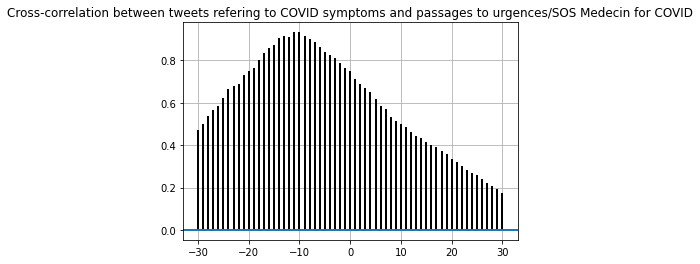

In [24]:
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import matplotlib as mpl
import matplotlib.pyplot as plt
import quandl
import scipy.stats as stats

#Variables
plt.xcorr(tweets_symptoms['has_symptom'][:-1][-64:], urgences['nbre_pass_corona'], normed=True, usevlines=True, maxlags=30, lw=2)
plt.grid(True)
plt.title("Cross-correlation between tweets refering to COVID symptoms and passages to urgences/SOS Medecin for COVID")
plt.show()

In [25]:
tweets_symptoms['symptom_shift'] = tweets_symptoms['has_symptom'].shift(11)

def plot_symptoms_urgences_shift() :
    traces=[]
    traces.append(go.Scatter(x = tweets_symptoms['day'], 
                            y = tweets_symptoms['symptom_shift'].values,
                            mode = 'lines',
                            name = 'symptom_shift',
                            yaxis="y1"))
    for type_urgence in ['nbre_pass_corona','nbre_hospit_corona','nbre_acte_corona']:
        traces.append(go.Scatter(x = urgences.date_de_passage, 
                                 y = urgences[type_urgence],
                                 mode = 'lines',
                                 name = type_urgence,
                                 yaxis="y2"))
    
    layout = go.Layout(title="Evolution of mentions of Covid-related terms in Ile-de-France",
                       yaxis=dict(title='Number of tweets'),
                       yaxis2=dict(title='Number of acts in urgences',
                                   overlaying='y',
                                   side='right'))
    
    fig = go.Figure(traces, layout)
    py.iplot(fig)
    
plot_symptoms_urgences_shift()

In [26]:
r, p = stats.pearsonr(tweets_symptoms['symptom_shift'][:-1][-64:], urgences['nbre_pass_corona'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.8707047583034431 and p-value: 8.978509292049961e-21


On représente ci-dessus toutes nos séries temporelles, avec la série des tweets mentionnant des symptômes liés au COVID shiftée de 11 jours. On constate que les courbes semblent être très similaires : la corrélation de Pearson entre ces deux courbes est de 0.87.

Ainsi, les données optenues via Twitter en Île-de-France semblent être un assez bon indicateur de l'évolution du COVID dans cette région. Le décalage de 11 jours entre les tweets et les passages aux urgences pour des suspicions de COVID est par ailleurs assez comparable au délai d'agravation de la maladie. 

On peut bien évidemment nuancer ce résultat qui se base sur trop peu de tweets et d'utilisateurs ; par ailleurs, on ne regarde ici que les urgences hospitalières, mais on ne prend pas en compte les cas de COVID en Ephad par exemple. Il serait toutefois intéressant d'étudier d'autres régions, ou à d'autres échelles (département, ville,...) afin de voir si on observe une corrélation similaire entre l'évolution des tweets et l'évolution de la propagation de l'épidémie.

# 3. Sentiment analysis

On effectue dans un second temps une analyse de sentiment sur les tweets liés au COVID et à la quarantaine. L'objectif est d'étudier dans quelle mesure l'opinion vis à vis de l'épidémie - et des mesures engendrées - a évolué au cours du temps.

Les difficultés pour effectuer ce type d'analyse est que nos données sont en français, et il existe peu de jeux de donnés labellisés avec des sentiments en Français.

Dans un cadre non supervisé, certains chercheurs ont mis au point des techniques basées sur des lexiques de mots labelisés, ou auxquels on a attribué un score (lexicon-based sentiment analysis). Nous adoptons donc cette technique, en utilisant divers lexiques de mots labellisés.

## 3.1. Preprocessing

Dans cette partie, on preprocess les données.

On conserve les tweets uniquement en 2020 (on n'a plus besoin de la comparaison avec décembre 2019, qui ne nous importait que pour la distinction avec la grippe), et les tweets mentionnant le covid, ou le confinement.

On tokenize ensuite (en enlevant les mentions des individus, les "#" devant les hashtags les liens http), afin de récupérer les mots dans chacun des tweets, dont on pourra étudier le sentiment en fonction des lexiques.

On groupe ensuite nos données par jour, pour plus de rapidité.

In [10]:
# We don't keep tweets before Covid
tweets_covid = tweets.loc[tweets['created_at'] > '2020-01-01']

# Only keep tweets about covid
tweets_covid = tweets_covid[(tweets_covid['covid']==1) | (tweets_covid['confinement']==1) | (tweets_covid['RestezChezVous']==1)]
tweets_covid = tweets_covid[tweets_covid['lang']=='fr']

In [11]:
# Tokenization
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
import re

def remove_hashtags(tokens):
    tokens = map(lambda x: x.replace('#', ''), tokens)
    return list(tokens)

def remove_url(tokens):
    tokens = filter(lambda x: "http" not in x, tokens)
    return list(tokens)

def remove_html(tokens):
    tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
    return list(tokens)

def remove_mentions(tokens):
    tokens = filter(lambda x: "@" not in x, tokens)
    return list(tokens)

def remove_rt(tokens):
    tokens = filter(lambda x: 'rt' not in x, tokens)
    return list(tokens)

from tqdm import tqdm
def tokenize_url_hashtags(corpus):
    tokenizer = TweetTokenizer()
  
    tokenized_sentences = []
    for sample in tqdm(corpus):
    # separating sentences
        #for sentence in sent_detector.tokenize(sample):
        tokens = tokenizer.tokenize(sample)
        tokens = remove_url(tokens)
        tokens = remove_html(tokens)
        tokens = remove_hashtags(tokens)
        tokens = remove_mentions(tokens)
        tokens = remove_rt(tokens)
        tokens = list(map(lambda x: x.lower(), tokens))
        tokenized_sentences.append(tokens)
    return tokenized_sentences

tweets_covid['tokens'] = tokenize_url_hashtags(tweets_covid['full_text'].array)

unable to import 'smart_open.gcs', disabling that module
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 443397/443397 [01:09<00:00, 6382.14it/s]


In [12]:
# Using dask because the dataframe is too big
import dask.dataframe as dd
df = dd.from_pandas(tweets_covid, 1000)
tweets_covid_day = df.groupby('day').agg({'tokens':'sum'}).reset_index().compute()
tweets_covid_day['day'] = pd.to_datetime(tweets_covid_day['day'])
tweets_covid_day=tweets_covid_day.sort_values(by='day')

In [30]:
print("Nombre de tweets pour l'analyse de sentiments : %d" %len(tweets_covid))

Nombre de tweets pour l'analyse de sentiments : 443397


## 3.2. Lexicon-based sentiment analysis

### 3.2.1. Sentiment analysis using hedonometer

Le premier lexique utilisé est celui construit par Peter Sheridan Dodds & al. en 2011 (Réference : https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#pone-0026752-g002). Il s'agit d'un grand lexique de termes en plusieurs langues, et pour chaque terme a été attribué une intensité de bonheur. Une application est visible sur leur page web : https://hedonometer.org/timeseries/en_all/.

Leur méthode pour construire le sentiment émanant d'un tweet est également décrit dans leur article. On rappelle la formule ici. Pour un texte (ici tweet) $T$, le niveau de bonheur est évalué à $h_{avg}(T)$, calculé comme
$$h_{avg}(T) = \frac{\sum\limits_{i=1}^{N}h_{avg}(w_i)f_i}{\sum\limits_{i=1}^{N}f_i} = \sum\limits_{i=1}^{N}h_{avg}(w_i)p_i $$
où $f_i$ est la fréquence du $i$ème mot $w_i$ pour lequel on a une estimation du niveau de bonheur $h_{avg}(w_i)$ (c'est-à-dire que le mot $w_i$ est inclus dans le lexique) ; et $p_i = \frac{f_i}{\sum\limits_{i=1}^{N}f_{i}}$ est la fréquence normalisée de ce mot.

Pour accélérer le processus, on parallélise la construction de ce score, en attribuant à chaque processus un échantillon aléatoire de lignes (correspondant aux jours), puisque le nombre de tweets se référant au COVID est différent chaque jour.

In [13]:
# Loading data
french_lexicon = pd.read_csv(os.path.join(path_to_external_data, "hedonometer/Hedonometer.csv"), sep=',')

In [14]:
# Compute score with hedonometer lexicon
def compute_hedonometer_score(dataframe, n_blocks, index_block):
    big_df=pd.DataFrame()
    df = dataframe[n_blocks*index_block:n_blocks*(index_block+1)]
    hedonometer_words = french_lexicon['Word'].tolist()
    hedonometer_dict = dict(french_lexicon[['Word','Happiness Score']].values)
    
    def hedonometer_score(text) :
        words_text = [x for x in text if x in hedonometer_words]    
        happiness_list = [hedonometer_dict.get(item) for item in words_text]
        happiness_score = sum(happiness_list)/len(words_text)
        return happiness_score
    
    df['hedonometer_score'] = df['tokens'].apply(lambda x: hedonometer_score(x))
    big_df = pd.concat([big_df,df])
    
    return big_df

In [15]:
# We randomize the rows so that the different cores have similar length data
tweets_covid_day = tweets_covid_day.reindex(np.random.permutation(tweets_covid_day.index))

In [16]:
n_cpu = mp.cpu_count()
print('USE DEFAULT # CORES')
pool  = mp.Pool(processes=n_cpu)
print("# PROCESSORS:", n_cpu, "\n")

print("Read Tweets ...")
start = time()

# COMPUTE LIST OF RESULTS
n_blocks= len(tweets_covid_day)//n_cpu + len(tweets_covid_day)%n_cpu
print(n_blocks)
results = [pool.apply_async(compute_hedonometer_score, args=(tweets_covid_day,n_blocks,index_block)) for index_block in range(n_cpu)]
print(results)
tweets_hedonometer = pd.concat([results[index_block].get() for index_block in range(n_cpu)]).reset_index(drop=True)
print('done')
#print(tweets)

pool.close()    
print("DONE IN", round(time() - start), "SEC")

USE DEFAULT # CORES
# PROCESSORS: 16 

Read Tweets ...
13
[<multiprocessing.pool.ApplyResult object at 0x7ffa46c93950>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c93b90>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c93e10>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c93f50>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a890>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a7d0>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a3d0>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a590>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a250>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a750>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a1d0>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a310>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c9a710>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c8b950>, <multiprocessing.pool.ApplyResult object at 0x7ffa46c8b990>, <multiprocessing.pool.Appl

In [17]:
tweets_hedonometer = tweets_hedonometer.sort_values(by='day')

In [20]:
def plot_sentiment_evolution_hedonometer(df) :
    traces=[]
    traces.append(go.Scatter(x = df['day'], 
                                 y = df['hedonometer_score'].values,
                                mode = 'lines',
                                name = 'hedonometer_score'))
    layout = go.Layout(title="Evolution of sentiment in Ile-de-France - Hedonometer")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_sentiment_evolution_hedonometer(tweets_hedonometer)

On obtient alors une courbe d'évolution du bonheur, pour les tweets mentionnant l'épidémie de COVID. On peut peut-être ignorer le sentiment des tweets de début janvier, qui semblent être très biaisés (puisqu'il y a très peu de tweets à cette période) ; et on constate que le bonheur lié aux tweets à propos du COVID est assez faible en février, puis tend à augmenter, même si cette évolution n'est pas très marquante.

### 3.2.2. Emotion based using FEEL

Dans un second temps, on utilise une seconde base de données, la base FEEL, qui est également labellisée. Elle a été mise au point en 2016 par Amine Abdaoui et al. (https://hal-lirmm.ccsd.cnrs.fr/lirmm-01348016). A l'inverse des données précédentes, cette base associe, à chaque terme, un sentiment (positif ou négatif), ainsi qu'une ou plusieurs émotions (joie, colère, tristesse, peur, surpise, dégoût). 

De la même façon que pour la base précédente, on construit un score pour chaque sentiment ou émotion ; et on les représente graphiquement.

In [21]:
# Loading data
feel_lexicon = pd.read_csv(os.path.join(path_to_external_data, "feel/FEEL.csv"), sep=';')

In [22]:
def create_list_polarity(polarity):
    return feel_lexicon.loc[feel_lexicon['polarity']==polarity, 'word'].tolist()
def create_list_emotions(emotion):
    return feel_lexicon.loc[feel_lexicon[emotion]==1, 'word'].tolist()

In [23]:
# Creation of lists of words
positive_words = create_list_polarity('positive')
negative_words = create_list_polarity('negative')

joy_words = create_list_emotions('joy')
fear_words = create_list_emotions('fear')
sadness_words = create_list_emotions('sadness')
anger_words = create_list_emotions('anger')
surprise_words = create_list_emotions('surprise')
disgust_words = create_list_emotions('disgust')

all_feel_lexicon_words = feel_lexicon['word'].tolist()

In [24]:
# Compute score with lexicon
def compute_feel_score(dataframe, n_blocks, index_block):
    big_df=pd.DataFrame()
    df = dataframe[n_blocks*index_block:n_blocks*(index_block+1)]
    
    def keep_useful_words(text):
        return [x for x in text if x in all_feel_lexicon_words]
    
    df['feel_tokens'] = df['tokens'].apply(lambda x: keep_useful_words(x))

    def feel_score(text, emotion_words) :
        words_text = [x for x in text if x in emotion_words]
        score = len(words_text)/len(text)
        return score
    

    def apply_function(emotion_words):
        return df['feel_tokens'].apply(lambda x: feel_score(x, emotion_words))
    
    
    df['positive_feel_score'] = apply_function(positive_words)
    df['negative_feel_score'] = apply_function(negative_words)
    
    df['joy_feel_score'] = apply_function(joy_words)
    df['fear_feel_score'] = apply_function(fear_words)
    df['sadness_feel_score'] = apply_function(sadness_words)
    df['anger_feel_score'] = apply_function(anger_words)
    df['surprise_feel_score'] = apply_function(surprise_words)
    df['disgust_feel_score'] = apply_function(disgust_words)


    big_df = pd.concat([big_df,df])
    return big_df

In [25]:
# We randomize the rows so that the different cores have similar length data
tweets_covid_day = tweets_covid_day.reindex(np.random.permutation(tweets_covid_day.index))

n_cpu = mp.cpu_count()
print('USE DEFAULT # CORES')
pool  = mp.Pool(processes=n_cpu)
print("# PROCESSORS:", n_cpu, "\n")

print("Read Tweets ...")
start = time()

# COMPUTE LIST OF RESULTS
n_blocks= len(tweets_covid_day)//n_cpu + len(tweets_covid_day)%n_cpu
print(n_blocks)
results = [pool.apply_async(compute_feel_score, args=(tweets_covid_day,n_blocks,index_block)) for index_block in range(n_cpu)]
print(results)
tweets_feel = pd.concat([results[index_block].get() for index_block in range(n_cpu)]).reset_index(drop=True)
print('done')
#print(tweets)

pool.close()   
print("DONE IN", round(time() - start), "SEC")

USE DEFAULT # CORES
# PROCESSORS: 16 

Read Tweets ...
13
[<multiprocessing.pool.ApplyResult object at 0x7ff3c6a0b290>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0b110>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0b2d0>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a17090>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a17590>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0c510>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0c690>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0ca50>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0c610>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a17290>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0cb50>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0cb10>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0cbd0>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0cd50>, <multiprocessing.pool.ApplyResult object at 0x7ff3c6a0ce10>, <multiprocessing.pool.Appl

In [26]:
tweets_feel = tweets_feel.sort_values(by='day')

In [27]:
def plot_sentiment_evolution_feel(dataframe) :
    traces=[]
    sentiments = ['positive','negative']
    df = dataframe[['day'] + [sentiment+'_feel_score' for sentiment in sentiments]]
    for sentiment in sentiments :
        traces.append(go.Scatter(x = df['day'], 
                                 y = df[sentiment+'_feel_score'].values,
                                mode = 'lines',
                                name = sentiment))
    layout = go.Layout(title="Evolution of sentiments in Ile-de-France - FEEL")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_sentiment_evolution_feel(tweets_feel)

In [28]:
def plot_emotion_evolution_feel(dataframe) :
    traces=[]
    emotions = ['joy','fear','sadness','anger','surprise','disgust']
    df = dataframe[['day'] + [ emotion+'_feel_score' for emotion in emotions]]
    for emotion in emotions :
        traces.append(go.Scatter(x = df['day'], 
                                 y = df[emotion+'_feel_score'].values,
                                mode = 'lines',
                                name = emotion))
    layout = go.Layout(title="Evolution of emotions in Ile-de-France - FEEL")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_emotion_evolution_feel(tweets_feel)

Une fois encore, les résultats obtenus ne sont pas flagrants. On observe que le signal en janvier est très brouillé, probablement en raison du faible nombre de tweets liés au COVID à cette période-là. Par ailleurs, pour les émotions, on observe davantage de peur que tout autre sentiment, mais la différence n'est pas très importante et il y a peu d'évolution au cours du temps.

Un des échecs de cette méthode peut être attribué à la construction des différents scores de sentiment, qui ne se basent que sur les poids. On aurait pu prendre en compte davantage les émoticons (fortement utilisés dans les tweets), par exemple. 

Par ailleurs, en disposant d'un jeu d'entraînement ou de données labellisées, on aurait également pu entraîner un modèle, ce qui aurait pu améliorer notre qualité de prédiction des sentiments dans les tweets. Le seul jeu de tweets labellisé en français (https://www.kaggle.com/hbaflast/french-twitter-sentiment-analysis) est basé sur des tweets en anglais, et a ensuite été traduit automatiquement en Français ; cela pose problème dans la mesure où les tweets comprennent souvent des expressions familières, pour lesquelles les traductions automatiques ne sont pas vraiment efficaces (nous avons testé quelques modèles sur ces données, sans obtenir des résultats convainquants).

# Conclusion

Dans notre projet, nous avons cherché à voir ce que les données Twitter peuvent nous dire de la population francilienne en cette période d'épidémie. 

D'une part, on a cherché à voir si les mentions de symptômes de COVID19 sont corrélés avec l'évolution de l'épidémie en Île-de-France. D'après les données analysées, la corrélation est très importante, avec un lag de 11 jours, ce qui correspond à peu près à la durée entre l'apparition des symptômes et les complications. Une poursuite de ces travaux pourrait être de travailler sur des tweets d'autres régions, ou à une autre échelle, pour voir si on fait le même constat.

D'autre part, on a cherché à étudier l'évolution des sentiments vis-à-vis du COVID sur les tweets. En l'absence de données et probablement en raison d'une modélisation un peu trop basique, nous n'avons pas obtenu des résultats très convainquants.